In [1]:
%load_ext rpy2.ipython

In [2]:
%%R
workDir = '/home/chantal/Chazy/Bulk/ITS/data/'
figDir = '/home/chantal/Chazy/Bulk/ITS/data/figs/'

physeqDir = '/home/chantal/Chazy/data/phyloseq/ITS/'
physeqBulk = 'bulk-core'


nprocs = 20

In [3]:
%%R
library(phyloseq)
library(tidyr)
library(plyr); library(dplyr)
library(DESeq2)
library(foreach)
library(doParallel)
library(ggplot2)
library(gridExtra)
library(reshape2)
library(RColorBrewer)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘dplyr’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/f

#### Read in sample metadata and OTU table

In [4]:
%%R

F = file.path(physeqDir, physeqBulk)
print(F)
physeq.Bulk = readRDS(F)
physeq.Bulk.m = physeq.Bulk %>% sample_data
physeq.Bulk = prune_samples((physeq.Bulk.m$Land_Management != "PAS"),
                           physeq.Bulk)
physeq.Bulk.m = physeq.Bulk %>% sample_data


physeq.Bulk

[1] "/home/chantal/Chazy/data/phyloseq/ITS//bulk-core"
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2412 taxa and 176 samples ]
sample_data() Sample Data:       [ 176 samples by 24 sample variables ]
tax_table()   Taxonomy Table:    [ 2412 taxa by 7 taxonomic ranks ]


In [5]:
%%R
mdf = psmelt(physeq.Bulk)

In [6]:
%%R
samples = mdf %>% group_by(Sample) %>% summarise(seqs = sum(Abundance))
range(samples$seqs)

[1]  1712 10000


In [7]:
%%R
summary(samples$seqs)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1712    3383    6377    6242    9560   10000 


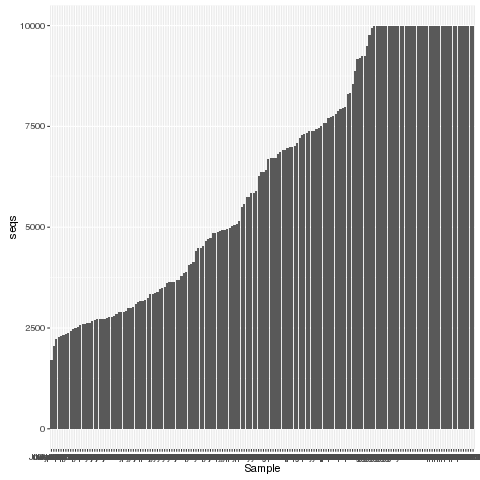

In [8]:
%%R
samples$Sample <- factor(samples$Sample, levels = samples$Sample[order(samples$seqs)])
ggplot(data = samples, aes(Sample, seqs)) + geom_bar(stat = 'identity')

In [9]:
%%R
samples %>% arrange(seqs) %>% head(n=20)

Source: local data frame [20 x 2]

         Sample  seqs
         (fctr) (dbl)
1    June.NTH.4  1712
2     Nov.NTH.4  2057
3     Oct.NTH.4  2229
4  July15.NTH.4  2287
5    June.PTR.3  2292
6   April.PTR.2  2324
7    June.PTH.1  2353
8    June.NTH.1  2379
9   April.NTR.3  2420
10   Sept.NTR.3  2465
11  April.PTR.4  2507
12 July15.NTR.3  2536
13    Nov.NTH.2  2583
14   Sept.NTH.2  2596
15    Oct.PTR.2  2612
16 July15.PTH.2  2615
17   Sept.PTH.3  2630
18    Oct.NTH.1  2677
19   June.PTH.2  2709
20    Oct.PTH.4  2719


In [10]:
%%R
summary(samples$seqs)

## rarefy to 10,000, but keep in samples at 2500

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1712    3383    6377    6242    9560   10000 


In [11]:
%%R
test= arrange(samples, seqs) %>% head(n = 22)
tail(test)

Source: local data frame [6 x 2]

        Sample  seqs
        (fctr) (dbl)
1   Sept.PTH.3  2630
2    Oct.NTH.1  2677
3   June.PTH.2  2709
4    Oct.PTH.4  2719
5 July15.NTH.1  2720
6    Oct.PTH.1  2728


In [12]:
%%R
meta = read.csv('/home/chantal/Chazy/Chazy_SIP/ITS/data/Metadata_ChazyITS_all_wDensity.txt', sep = '\t', header = TRUE)
head(meta)

  Full.sample Fraction PrimerF PrimerR Barcode Rev.index Fwd.index Treatment
1 April.NTH.2       NA  nBITSf   58A2r     145  acgtgcgc  atcgtacg       NTH
2 April.NTH.3       NA  nBITSf   58A2r     149  acgtgcgc  tcatcgag       NTH
3 April.NTH.4       NA  nBITSf   58A2r     153  atagtacc  atcgtacg       NTH
4 April.NTR.1       NA  nBITSf   58A2r     143  gtaacgag  ggatatct       NTR
5 April.NTR.2       NA  nBITSf   58A2r     147  acgtgcgc  tagcgagt       NTR
6 April.NTR.3       NA  nBITSf   58A2r     151  acgtgcgc  ggatatct       NTR
  Day Pool     Experiment Gradient gradient_date fractionation_date BD
1  NA    4 Chazy.ITS.Bulk     <NA>          <NA>               <NA> NA
2  NA    4 Chazy.ITS.Bulk     <NA>          <NA>               <NA> NA
3  NA    4 Chazy.ITS.Bulk     <NA>          <NA>               <NA> NA
4  NA    4 Chazy.ITS.Bulk     <NA>          <NA>               <NA> NA
5  NA    4 Chazy.ITS.Bulk     <NA>          <NA>               <NA> NA
6  NA    4 Chazy.ITS.Bulk     <NA> 

In [11]:
%%R
reseq = filter(meta, Full.sample %in% test$Sample) %>% select(Full.sample, Pool, Barcode, Year) %>%
         arrange(Barcode) %>% as.data.frame()
write.csv(reseq, file = 'data/Bulk_ITS_SamplesReseq.csv')
reseq

    Full.sample Pool Barcode Year
1    Sept.NTH.2    4      89 2014
2    Sept.NTR.3    4      94 2014
3    Sept.PTH.3    4      98 2014
4     Oct.NTH.1    4     104 2014
5     Oct.NTH.4    4     107 2014
6     Oct.PTH.1    4     113 2014
7     Oct.PTH.4    4     116 2014
8     Oct.PTR.2    4     118 2014
9     Nov.NTH.2    4     122 2014
10    Nov.NTH.4    4     124 2014
11  April.PTR.2    4     146 2015
12  April.NTR.3    4     151 2015
13  April.PTR.4    4     154 2015
14   June.PTH.1    4     157 2015
15   June.NTH.1    4     158 2015
16   June.PTH.2    4     161 2015
17   June.PTR.3    4     168 2015
18   June.NTH.4    4     171 2015
19 July15.NTH.1    4     176 2015
20 July15.PTH.2    4     179 2015
21 July15.NTR.3    4     186 2015
22 July15.NTH.4    4     188 2015


In [13]:
%%R
mdf_sum = mdf %>% group_by(Month, Year, Till) %>% summarise(seqs = sum(Abundance))
mdf_sum$M = paste(mdf_sum$Month, mdf_sum$Year, sep = '-')
mdf_sum$MY = paste(mdf_sum$Month, mdf_sum$Year, mdf_sum$Till, sep = '-')
mdf_sum$MY <- factor(mdf_sum$MY, levels = mdf_sum$MY[order(mdf_sum$seqs)])

In [14]:
%%R
mdf_sum2 = mdf %>% group_by(Sample, Month, Year) %>% summarise(seqs = sum(Abundance)) %>% arrange(-seqs)
head(mdf_sum2, n = 20)

Source: local data frame [20 x 4]
Groups: Sample, Month [20]

             Sample  Month  Year  seqs
              (chr) (fctr) (int) (dbl)
1  April.NTH.1.2015  April  2015  7721
2       April.NTH.2  April  2015  5848
3       April.NTH.3  April  2015  4077
4       April.NTH.4  April  2015  2778
5       April.NTR.1  April  2015  3386
6       April.NTR.2  April  2015  5838
7       April.NTR.3  April  2015  2420
8       April.NTR.4  April  2015  2754
9  April.PTH.1.2015  April  2015  7026
10      April.PTH.2  April  2015 10000
11      April.PTH.3  April  2015  2888
12      April.PTH.4  April  2015  5576
13      April.PTR.1  April  2015  3152
14      April.PTR.2  April  2015  2324
15      April.PTR.3  April  2015  5490
16      April.PTR.4  April  2015  2507
17   Aug.NTH.1.2015 August  2015 10000
18   Aug.NTH.2.2015 August  2015 10000
19   Aug.NTH.3.2015 August  2015 10000
20   Aug.NTH.4.2015 August  2015 10000


In [15]:
%%R
filter(mdf_sum2, Month == "August", Year == '2015')

Source: local data frame [16 x 4]
Groups: Sample, Month [16]

           Sample  Month  Year  seqs
            (chr) (fctr) (int) (dbl)
1  Aug.NTH.1.2015 August  2015 10000
2  Aug.NTH.2.2015 August  2015 10000
3  Aug.NTH.3.2015 August  2015 10000
4  Aug.NTH.4.2015 August  2015 10000
5  Aug.NTR.1.2015 August  2015  6914
6  Aug.NTR.2.2015 August  2015 10000
7  Aug.NTR.3.2015 August  2015  7432
8  Aug.NTR.4.2015 August  2015 10000
9  Aug.PTH.1.2015 August  2015 10000
10 Aug.PTH.2.2015 August  2015 10000
11 Aug.PTH.3.2015 August  2015 10000
12 Aug.PTH.4.2015 August  2015 10000
13 Aug.PTR.1.2015 August  2015 10000
14 Aug.PTR.2.2015 August  2015 10000
15 Aug.PTR.3.2015 August  2015 10000
16 Aug.PTR.4.2015 August  2015 10000


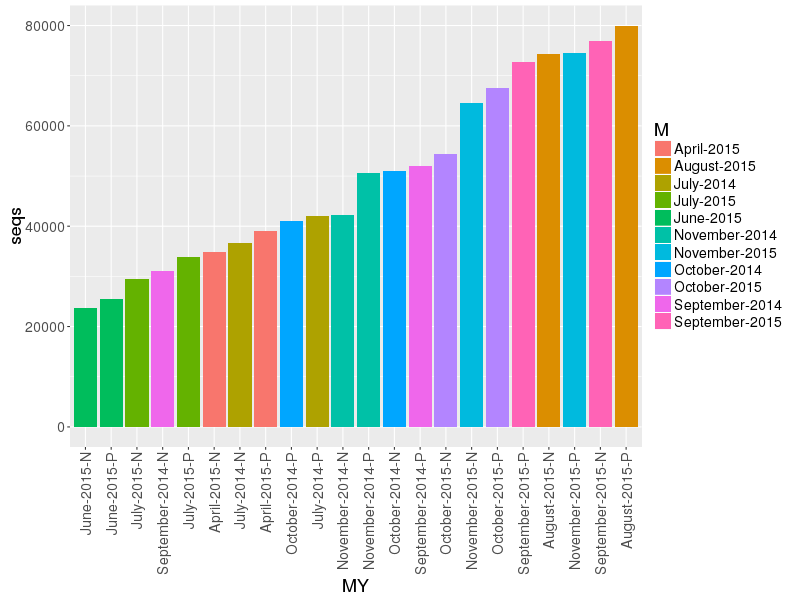

In [16]:
%%R -h 600 -w 800
pl = ggplot(data = mdf_sum, aes(MY, seqs, fill = M))
pl = pl + geom_bar(stat = 'identity') + theme(text = element_text(size=18),
        axis.title.y = element_text(vjust=1),
        axis.text.x = element_text(angle=90, vjust=0.5, hjust=1))
pl

In [16]:
%%R
get_l2fc = function(physeq.obj, Month, Year, sparsity_threshold) {
    physeq.md = sample_data(physeq.obj)
  
    p = prune_samples((physeq.md$Month == Month) &
                      (physeq.md$Year == Year), physeq.obj)
   
    p = filter_taxa(p, function(x) sum(x > 0) > sparsity_threshold * length(x), TRUE)
 
    dds = phyloseq_to_deseq2(p, ~ Till)
    dds = DESeq(dds, quiet = TRUE, fitType = "local")
        
    theta = 1
    r = results(dds, independentFiltering = FALSE)
    r$OTU = rownames(r)
   
    d = data.frame(r[, c("OTU","log2FoldChange", "lfcSE", "padj")])

   # d$padj = p.adjust(p, method = "BH")
    TT = data.frame(tax_table(p))
    TT$OTU = rownames(TT)
    d = left_join(d, TT)


    d
}

In [17]:
%%R

sdm = physeq.Bulk %>% sample_data %>% 
    filter(! is.na(Till)) %>%
    select(Month, Year) %>%
    distinct() %>%
    arrange(Year, Month) 

sdm %>% nrow %>% print
sdm %>% head(n=5)


[1] 11
      Month Year
1      July 2014
2  November 2014
3   October 2014
4 September 2014
5     April 2015


In [18]:
%%R
# adding range of sparsity thresholds (all pairwise)
sdms = sdm %>%
    unite(sdm, Month, Year, sep='___')

sdms = expand.grid(sdms$sdm,
                    sparsity_threshold = seq(0.05,0.95,0.05)) %>%
    separate(Var1, c('Month', 'Year'), sep='___')


cat('Number of pairwise combinations of variables:', sdms %>% nrow, '\n\n')
head(sdms) 

Number of pairwise combinations of variables: 209 

      Month Year sparsity_threshold
1      July 2014               0.05
2  November 2014               0.05
3   October 2014               0.05
4 September 2014               0.05
5     April 2015               0.05
6    August 2015               0.05


In [19]:
%%R
#For testing method
test = head(sdms, 5)
test

      Month Year sparsity_threshold
1      July 2014               0.05
2  November 2014               0.05
3   October 2014               0.05
4 September 2014               0.05
5     April 2015               0.05


In [20]:
%%R
registerDoParallel(8)

df.l2fc = tbl_df(mdply(sdms, 
                       get_l2fc, 
                       .parallel = TRUE, 
                       physeq.obj = physeq.Bulk))
df.l2fc

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:1

Source: local data frame [50,751 x 14]

   Month  Year sparsity_threshold       OTU log2FoldChange    lfcSE      padj
   (chr) (chr)              (dbl)     (chr)          (dbl)    (dbl)     (dbl)
1   July  2014               0.05 OTU.20472      -2.477044 1.958218 0.6428537
2   July  2014               0.05  OTU.7528       1.456384 2.088863 0.6428537
3   July  2014               0.05 OTU.20112      -2.220195 2.014517 0.6428537
4   July  2014               0.05  OTU.7100      -2.700886 2.297779 0.6428537
5   July  2014               0.05  OTU.6089      -1.889517 2.039641 0.6428537
6   July  2014               0.05  OTU.6711       2.550863 2.114296 0.6428537
7   July  2014               0.05 OTU.36384       1.456384 2.088863 0.6428537
8   July  2014               0.05  OTU.6084       1.273177 1.998531 0.6428537
9   July  2014               0.05  OTU.4087       1.903265 2.055151 0.6428537
10  July  2014               0.05  OTU.4797       2.998630 2.173962 0.6428537
..   ...   ...          

In [21]:
%%R
summarise(df.l2fc,
  meanl2fc = mean(log2FoldChange, na.rm = TRUE))

Source: local data frame [1 x 1]

    meanl2fc
       (dbl)
1 -0.0120279


In [22]:
%%R
summarise(df.l2fc,
  sdl2fc = sd(log2FoldChange, na.rm = TRUE))

Source: local data frame [1 x 1]

    sdl2fc
     (dbl)
1 2.321544


In [23]:
%%R
df.l2fc$padj2 = p.adjust(df.l2fc$padj, method = "BH")

In [24]:
%%R
df.l2fc$Till[df.l2fc$log2FoldChange > 0] = "NT"
df.l2fc$Till[df.l2fc$log2FoldChange <0] = "PT"

In [25]:
%%R
write.table(df.l2fc, "data/l2fc_NTvsPT_all", row.names = FALSE, sep = ",")

In [91]:
%%R
df.l2fc = read.table("data/l2fc_NTvsPT_all", header = TRUE, sep = ",")

In [92]:
%%R
head(df.l2fc)

  Month Year sparsity_threshold       OTU log2FoldChange    lfcSE      padj
1  July 2014               0.05 OTU.20472      -2.477044 1.958218 0.6428537
2  July 2014               0.05  OTU.7528       1.456384 2.088863 0.6428537
3  July 2014               0.05 OTU.20112      -2.220195 2.014517 0.6428537
4  July 2014               0.05  OTU.7100      -2.700886 2.297779 0.6428537
5  July 2014               0.05  OTU.6089      -1.889517 2.039641 0.6428537
6  July 2014               0.05  OTU.6711       2.550863 2.114296 0.6428537
        Rank1           Rank2           Rank3           Rank4           Rank5
1 k__Protista     p__Cercozoa c__unidentified o__unidentified f__unidentified
2 k__Protista     p__Cercozoa c__unidentified o__unidentified f__unidentified
3 k__Protista     p__Cercozoa c__unidentified o__unidentified f__unidentified
4 k__Protista     p__Cercozoa c__unidentified o__unidentified f__unidentified
5    k__Fungi p__unidentified c__unidentified o__unidentified f__unidentified


In [93]:
%%R

padj.cutoff = 0.05

df.l2fc.rejH = df.l2fc %>%
    filter(padj2 <= padj.cutoff) %>%
    group_by(sparsity_threshold, Month, Year, Till) %>%
    summarize(n_reject_hypo = n()) %>%
    ungroup

df.l2fc.rejH %>% head(n=6)

Source: local data frame [6 x 5]

  sparsity_threshold  Month  Year   Till n_reject_hypo
               (dbl) (fctr) (int) (fctr)         (int)
1               0.05  April  2015     NT             3
2               0.05  April  2015     PT             1
3               0.05 August  2015     NT            22
4               0.05 August  2015     PT            10
5               0.05   July  2014     NT             5
6               0.05   July  2014     PT             3


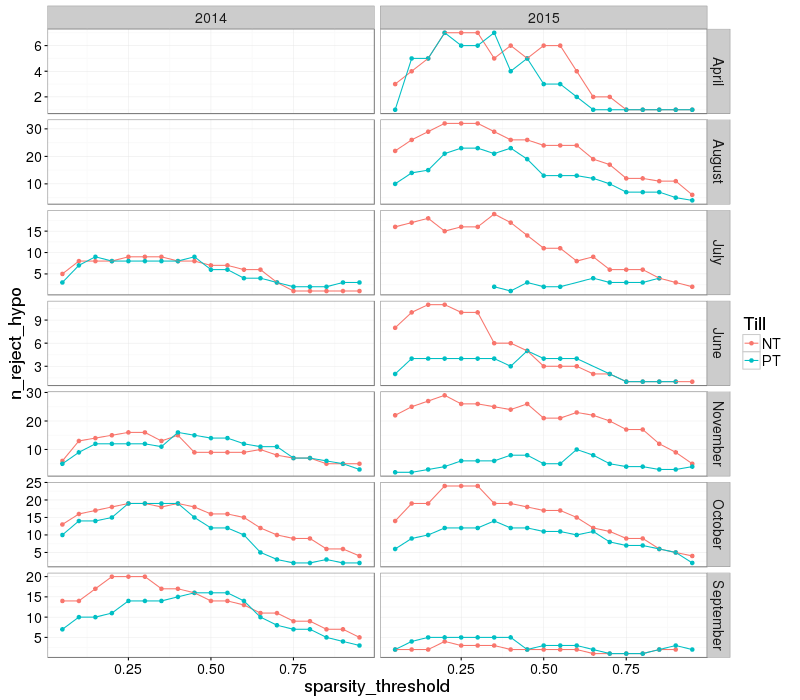

In [94]:
%%R -w 800 -h 700

df.l2fc.rejH$Month = reorder(df.l2fc.rejH$Month, df.l2fc.rejH$Month %>% as.numeric)

ggplot(df.l2fc.rejH, aes(sparsity_threshold, n_reject_hypo)) +
    geom_point(aes(color= Till)) +
    geom_line(aes(color = Till)) +
    facet_grid(Month ~ Year, scales = "free_y") +
    theme_bw() +
    theme(
        text = element_text(size=18)
        )

In [95]:
%%R
head(df.l2fc.rejH)

Source: local data frame [6 x 5]

  sparsity_threshold  Month  Year   Till n_reject_hypo
               (dbl) (fctr) (int) (fctr)         (int)
1               0.05  April  2015     NT             3
2               0.05  April  2015     PT             1
3               0.05 August  2015     NT            22
4               0.05 August  2015     PT            10
5               0.05   July  2014     NT             5
6               0.05   July  2014     PT             3


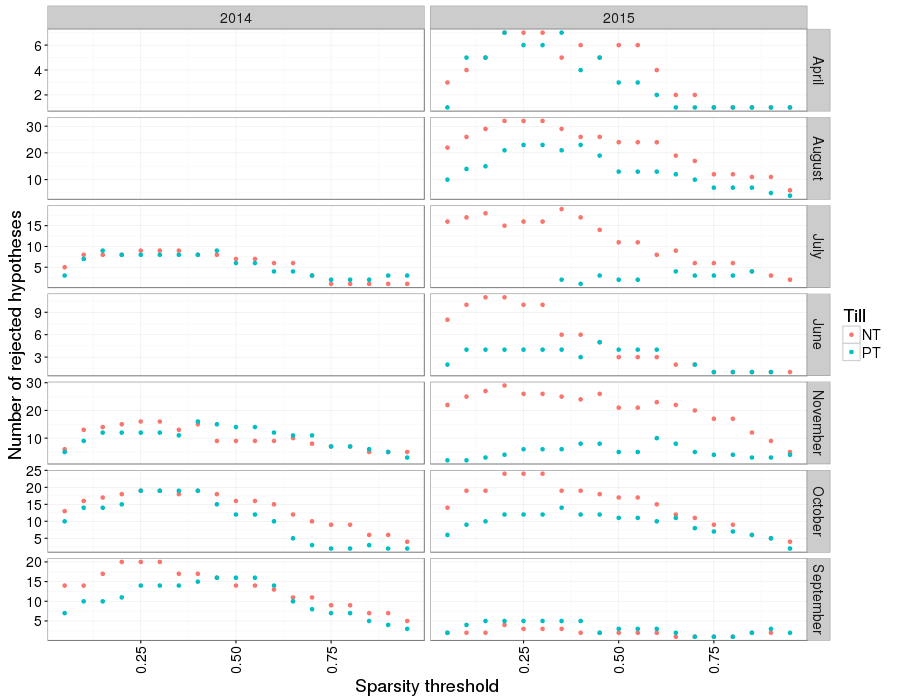

In [97]:
%%R -w 900 -h 700

df.l2fc.rejH = df.l2fc.rejH %>%
    mutate(Month = as.character(Month))

df.l2fc.rejH$Month = reorder(df.l2fc.rejH$Month, df.l2fc.rejH$Month %>% as.numeric)

ggplot(df.l2fc.rejH, aes(sparsity_threshold, n_reject_hypo, color = Till)) +
    geom_point() +
    labs(x='Sparsity threshold', y='Number of rejected hypotheses') +
    facet_grid(Month ~ Year,scales = "free_y" ) +
    theme_bw() +
    theme(
        text = element_text(size=18),
        axis.title.y = element_text(vjust=1),
        axis.text.x = element_text(angle=90, vjust=0.5, hjust=1)
        )

In [98]:
%%R

padj.cutoff = 0.05

df.l2fc.rejH.s = df.l2fc %>%
    filter(padj2 < padj.cutoff) %>%
    group_by(sparsity_threshold) %>%
    summarize(n_reject_hypo = n()) %>%
    ungroup

df.l2fc.rejH.s %>% head(n=3) %>% as.data.frame

  sparsity_threshold n_reject_hypo
1               0.05           173
2               0.10           232
3               0.15           254


In [99]:
%%R
# max number of rejected hypos 
max.rejH = df.l2fc.rejH.s %>%
    arrange(desc(n_reject_hypo)) %>%
    head(n=1)
max.rejH = max.rejH$sparsity_threshold
max.rejH

[1] 0.25


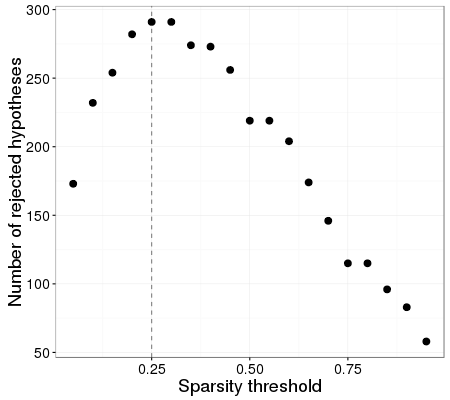

In [100]:
%%R -w 450 -h 400

ggplot(df.l2fc.rejH.s, aes(sparsity_threshold, n_reject_hypo)) +
    geom_point(size=3) +
    geom_vline(xintercept=max.rejH, linetype='dashed', alpha=0.5) +
    labs(x='Sparsity threshold', y='Number of rejected hypotheses') +
    theme_bw() +
    theme(
        text = element_text(size=18),
        axis.title.y = element_text(vjust=1)
        )

In [101]:
%%R
df.l2fc.f = df.l2fc %>%
    filter(sparsity_threshold == max.rejH) 

df.l2fc.f %>% nrow

[1] 3177


In [102]:
%%R #-i workDir
# Writing out l2fc table

outFile = 'data/l2fc_sparse-maxRejH_BULK.txt'
write.table(df.l2fc.f, 'data/l2fc_sparse-maxRejH_BULK.txt', sep='\t', quote=FALSE, row.names=FALSE)

In [103]:
%%R
df.l2fc = read.table('data/l2fc_sparse-maxRejH_BULK.txt', sep='\t', header = TRUE)

In [104]:
%%R
df.l2fc$Month = factor(df.l2fc$Month, levels = c("April", "June", "July", "August", "September", "October", "November"))


In [105]:
%%R
resp = df.l2fc %>% filter(padj2 <=0.05) %>% group_by(Month, Year, Till) %>% summarise(resp = n())
resp %>% as.data.frame

       Month Year Till resp
1      April 2015   NT    7
2      April 2015   PT    6
3       June 2015   NT   10
4       June 2015   PT    4
5       July 2014   NT    9
6       July 2014   PT    8
7       July 2015   NT   16
8     August 2015   NT   32
9     August 2015   PT   23
10 September 2014   NT   20
11 September 2014   PT   14
12 September 2015   NT    3
13 September 2015   PT    5
14   October 2014   NT   19
15   October 2014   PT   19
16   October 2015   NT   24
17   October 2015   PT   12
18  November 2014   NT   16
19  November 2014   PT   12
20  November 2015   NT   26
21  November 2015   PT    6


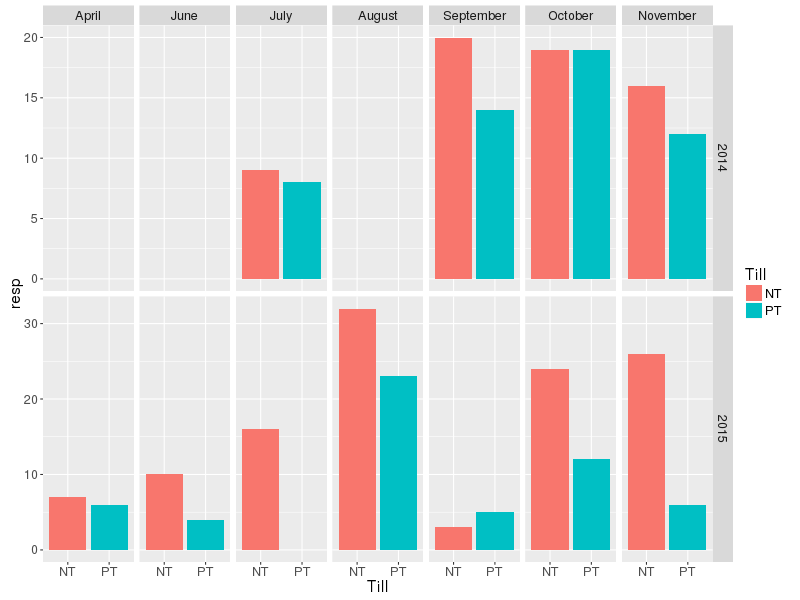

In [106]:
%%R -w 800 -h 600
ggplot(data = resp, aes(x = Till, y = resp, fill = Till)) +
    geom_bar(stat = 'identity') + facet_grid(Year~Month, scales = 'free_y')+
    theme(text = element_text(size=16))

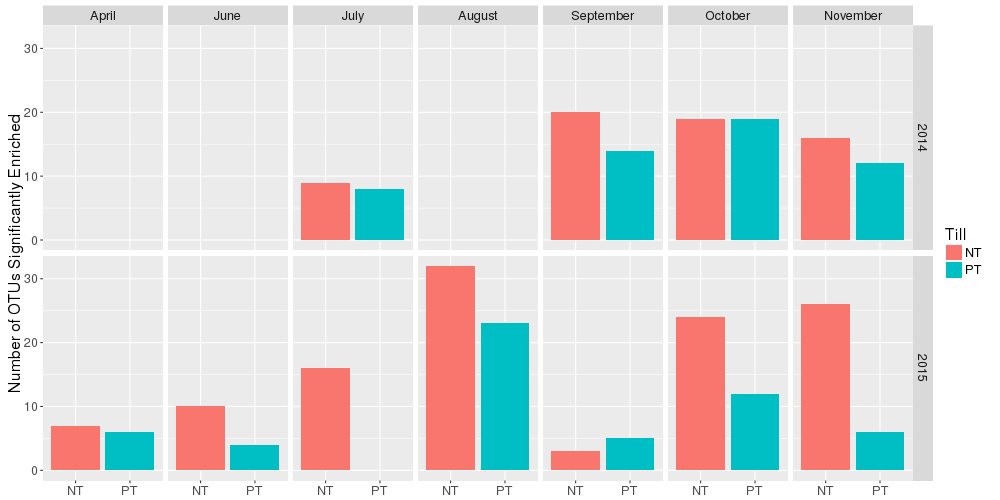

In [107]:
%%R -w 1000 -h 500
ggplot(data = resp, aes(x = Till, y = resp, fill = Till)) +
    geom_bar(stat = 'identity') + facet_grid(Year~Month) +
    theme(text = element_text(size=16)) + ylab("Number of OTUs Significantly Enriched") + xlab(NULL)

####Function arguments

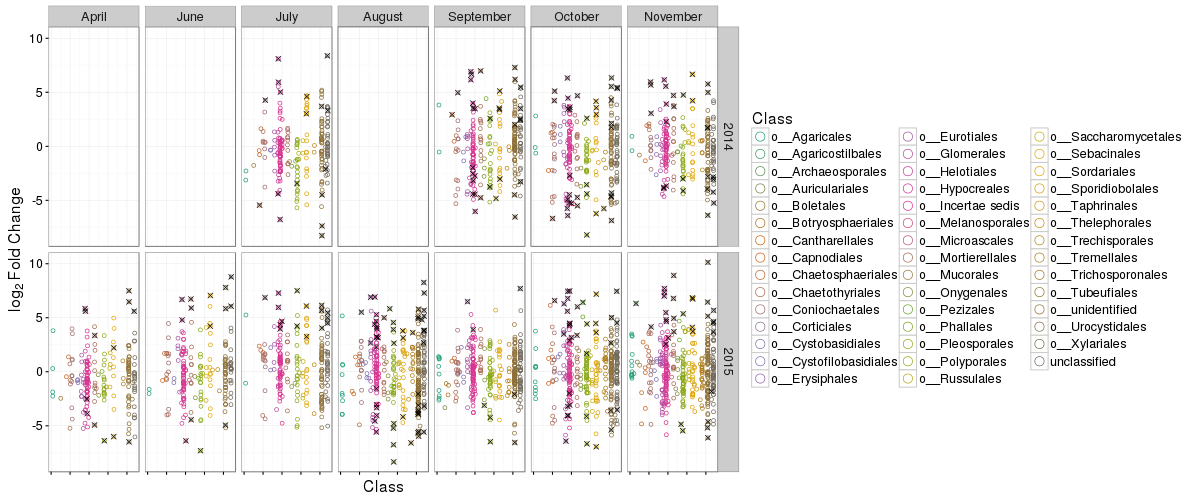

In [42]:
%%R -w 1200 -h 500
d = df.l2fc
FDR = 0.05

d$Rank4 = as.character(d$Rank4)
d$Rank4[is.na(d$Rank4)] = "unclassified"
d$Rank4 = factor(d$Rank4)

max.l2fc = ddply(d, .(Rank4), summarize, M = max(log2FoldChange))
d$Rank2 = factor(d$Rank4, max.l2fc[order(-max.l2fc$M),]$Rank4)

M = max(as.numeric(d$Rank4), na.rm = TRUE) + 1
d$x = as.numeric(d$Rank4)
d$x[is.na(d$x)] = M
d$x.jitter = d$x + runif(length(d$x), -1, 1) * 0.2

colourCount = length(unique(d$Rank4)) + 1
getPalette = colorRampPalette(brewer.pal(15, "Dark2"))

p = ggplot(d, aes(x = x.jitter, y = log2FoldChange, color = Rank4))
p = p + facet_grid(Year~Month)

p = p + geom_point(alpha = 1.00, shape = 21, size = 1.5)

p = p + scale_color_manual(values = getPalette(colourCount))

p = p + geom_point(data = subset(d, padj2 <= FDR), color = "black", shape = 4, size = 2)

#p = p + geom_hline(y = 1.3)

p = p + theme_bw()

p = p + theme(axis.text.x = element_blank())

p = p + labs(x = "Class", color = "Class")

p = p + guides(col = guide_legend(ncol = 2))

p = p + labs(y = expression(paste("", log[2]," Fold Change",sep="")))

p = p + guides(colour = guide_legend(override.aes = list(size=4))) +  
    theme(text = element_text(size=16)) #+ guides(color = FALSE)

p

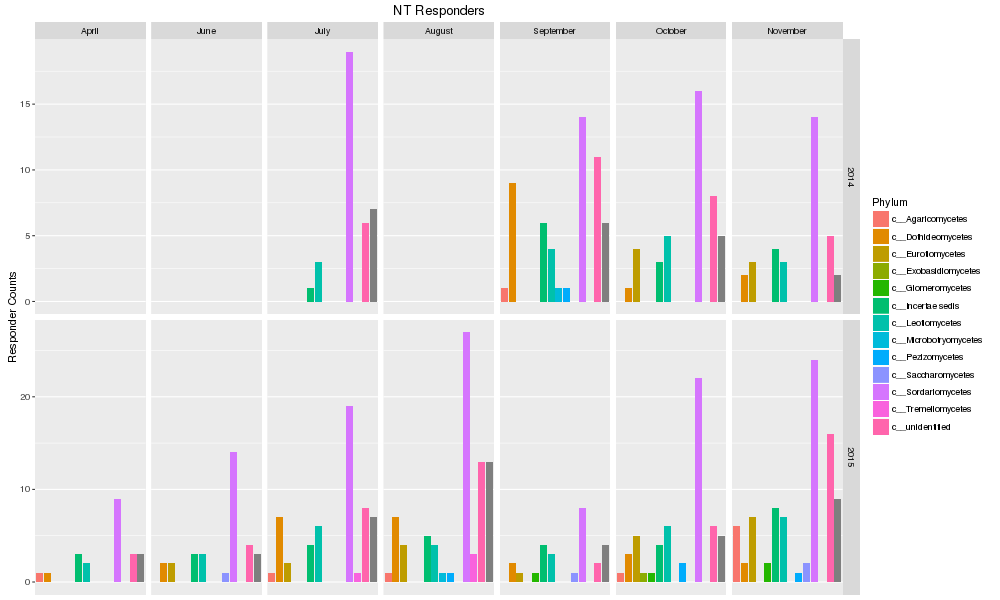

In [43]:
%%R -w 1000 -h 600
dcounts = df.l2fc %>%
          filter(!is.na(log2FoldChange)) %>%
          filter(!is.na(padj)) %>%
          filter(log2FoldChange > 0) %>%
          group_by(Rank3,Month, Year) %>%
          summarize(responders = sum(padj<= 0.10))
dcounts = filter(dcounts, responders > 0)
dcounts$Rank2 <- droplevels(dcounts$Rank3)
dcounts$Rank2 = reorder(dcounts$Rank3, -dcounts$responders)

p = ggplot(dcounts, aes(x = Rank3 , y = responders, fill = Rank3)) +
    geom_bar(stat = "identity") + scale_x_discrete(breaks=NULL, name = NULL) +
    facet_grid( Year ~ Month , scales = 'free_y') + ggtitle("NT Responders") + ylab("Responder Counts")+
    xlab("Phyla") + guides(fill=guide_legend(title="Phylum"))
    
    


p

In [44]:
%%R
ggsave(filename = "figs/NT_only_phyla.png", plot = p, width =8, height =6)


Error in grid.newpage() : could not open file 'figs/NT_only_phyla.png'


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in grid.newpage() : could not open file 'figs/NT_only_phyla.png'

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: In addition: 
  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Warning messages:

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 1: replacing previous import ‘S4Vectors::Position’ by ‘ggplot2::Position’ when loading ‘DESeq2’ 

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 2: 
  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packa

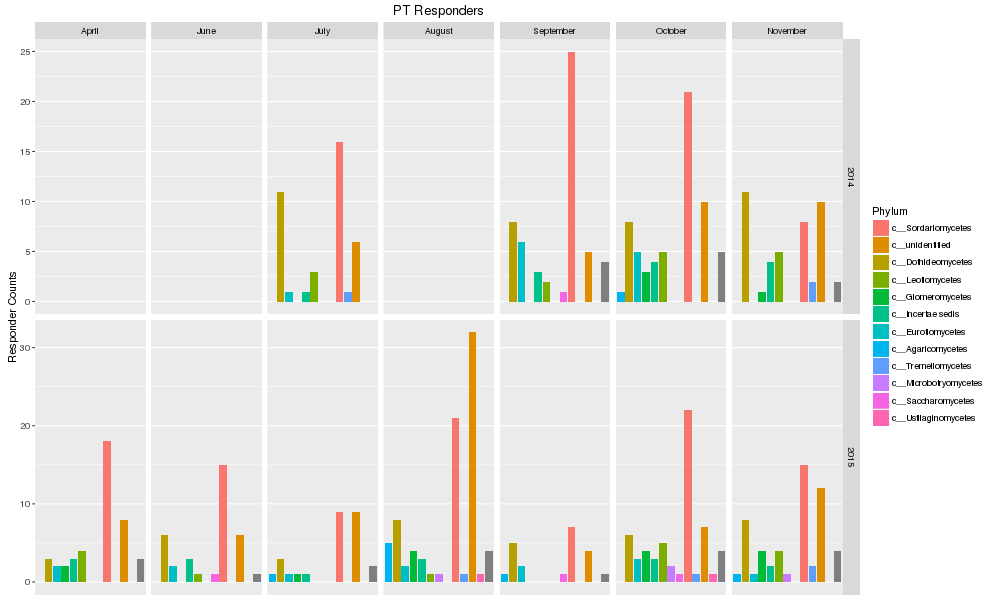

In [45]:
%%R -w 1000 -h 600
dcounts = df.l2fc %>%
          filter(!is.na(log2FoldChange)) %>%
          filter(!is.na(padj)) %>%
          filter(log2FoldChange < 0) %>%
          group_by(Rank3, Month, Year) %>%
          summarize(responders = sum(padj<= 0.10))
dcounts = filter(dcounts, responders > 0)
dcounts$Rank2 <- droplevels(dcounts$Rank3)
dcounts$Rank2 = reorder(dcounts$Rank3, -dcounts$responders)

p = ggplot(dcounts, aes(x = Rank3 , y = responders, fill = Rank2)) +
    geom_bar(stat = "identity") + scale_x_discrete(breaks=NULL, name = NULL) +
    facet_grid( Year ~ Month , scales = 'free_y') + ggtitle("PT Responders") + ylab("Responder Counts")+
    xlab("Phyla") + guides(fill=guide_legend(title="Phylum"))
    


p

In [46]:
%%R
ggsave(filename = "figs/PT_only_phyla.png", plot = p, width =8, height =6)


Error in grid.newpage() : could not open file 'figs/PT_only_phyla.png'


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in grid.newpage() : could not open file 'figs/PT_only_phyla.png'

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [47]:
%%R -w 800 -h 1000
dcounts = df.l2fc %>%
          filter(!is.na(log2FoldChange)) %>%
          filter(!is.na(padj)) %>%
          filter(log2FoldChange > 0) %>%
          group_by(Rank2,Month, Year, OM) %>%
          summarize(responders = sum(padj<= 0.10))
dcounts = filter(dcounts, responders > 0)
dcounts$Rank2 <- droplevels(dcounts$Rank2)
dcounts$Rank2 = reorder(dcounts$Rank2, -dcounts$responders)

p = ggplot(dcounts, aes(x = Month , y = responders, fill = Month)) +
    geom_bar(stat = "identity") + scale_x_discrete(breaks=NULL, name = NULL) +
    facet_grid(Year ~ Rank2 ~OM, scales = "free_y") + ggtitle("NT Responders") + ylab("Responder Counts") 
    


p


Error in eval(expr, envir, enclos) : unknown column 'OM'


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in eval(expr, envir, enclos) : unknown column 'OM'

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [48]:
%%R
ggsave(filename = "figs/NT_byphyla.png", plot = p, width =6, height =8)


Error in grid.newpage() : could not open file 'figs/NT_byphyla.png'


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in grid.newpage() : could not open file 'figs/NT_byphyla.png'

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [49]:
%%R
head(dcounts)

Source: local data frame [6 x 5]
Groups: Rank3, Month [6]

               Rank3     Month  Year responders              Rank2
              (fctr)    (fctr) (int)      (int)             (fctr)
1  c__Agaricomycetes      July  2015          1  c__Agaricomycetes
2  c__Agaricomycetes    August  2015          5  c__Agaricomycetes
3  c__Agaricomycetes September  2015          1  c__Agaricomycetes
4  c__Agaricomycetes   October  2014          1  c__Agaricomycetes
5  c__Agaricomycetes  November  2015          1  c__Agaricomycetes
6 c__Dothideomycetes     April  2015          3 c__Dothideomycetes


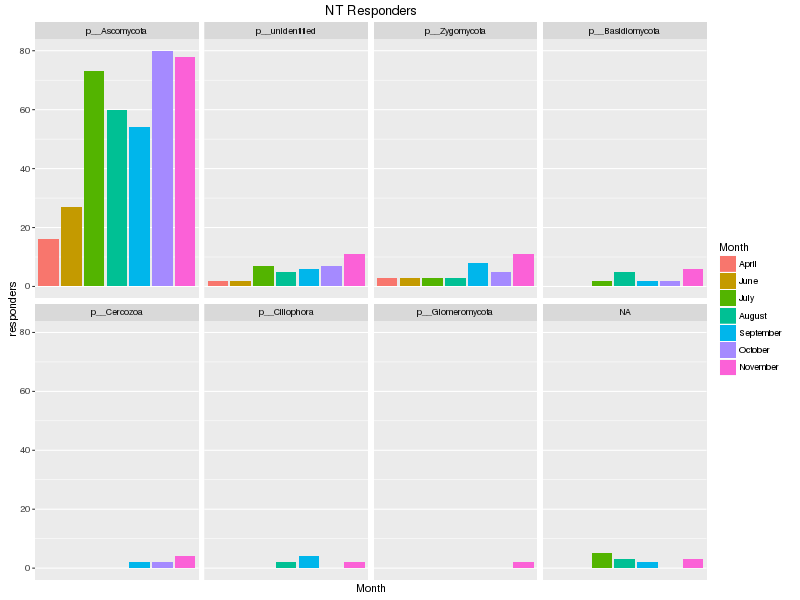

In [50]:
%%R -w 800 -h 600
dcounts = df.l2fc %>%
          filter(!is.na(log2FoldChange)) %>%
          filter(!is.na(padj)) %>%
          filter(log2FoldChange > 0) %>%
          group_by(Rank2,Month) %>%
          summarize(responders = sum(padj<= 0.10))
dcounts = filter(dcounts, responders > 1)
dcounts$Rank2 <- droplevels(dcounts$Rank2) 
dcounts$Rank2 = reorder(dcounts$Rank2, -dcounts$responders)


p = ggplot(dcounts, aes(x = Month , y = responders, fill = Month)) +
    geom_bar(stat = "identity") + scale_x_discrete(breaks=NULL) +
    facet_wrap( ~ Rank2, ncol = 4, nrow = 7) + ggtitle("NT Responders")


p

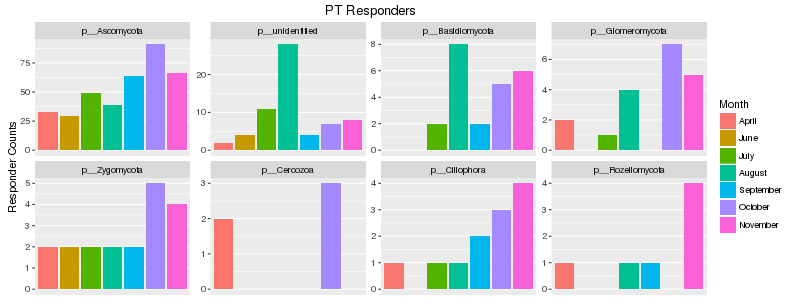

In [51]:
%%R -w 800 -h 300
dcounts = df.l2fc %>%
          filter(!is.na(log2FoldChange)) %>%
          filter(!is.na(padj)) %>%
          filter(log2FoldChange < 0) %>%
          group_by(Rank2,Month) %>%
          summarize(responders = sum(padj<= 0.10))
dcounts = filter(dcounts, responders > 0)
dcounts$Rank2 <- droplevels(dcounts$Rank2)
dcounts$Rank2 = reorder(dcounts$Rank2, -dcounts$responders)

p = ggplot(dcounts, aes(x = Month , y = responders, fill = Month)) +
    geom_bar(stat = "identity") + scale_x_discrete(breaks=NULL, name = NULL) +
    facet_wrap( ~ Rank2, scales = "free_y", ncol = 4, nrow = 7) + ggtitle("PT Responders") + ylab("Responder Counts") 
    


p

In [52]:
%%R
ggsave(filename = "figs/PT_byphyla.png", plot = p, width =6, height =8)


Error in grid.newpage() : could not open file 'figs/PT_byphyla.png'


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in grid.newpage() : could not open file 'figs/PT_byphyla.png'

  res = super(Function, self).__call__(*new_args, **new_kwargs)


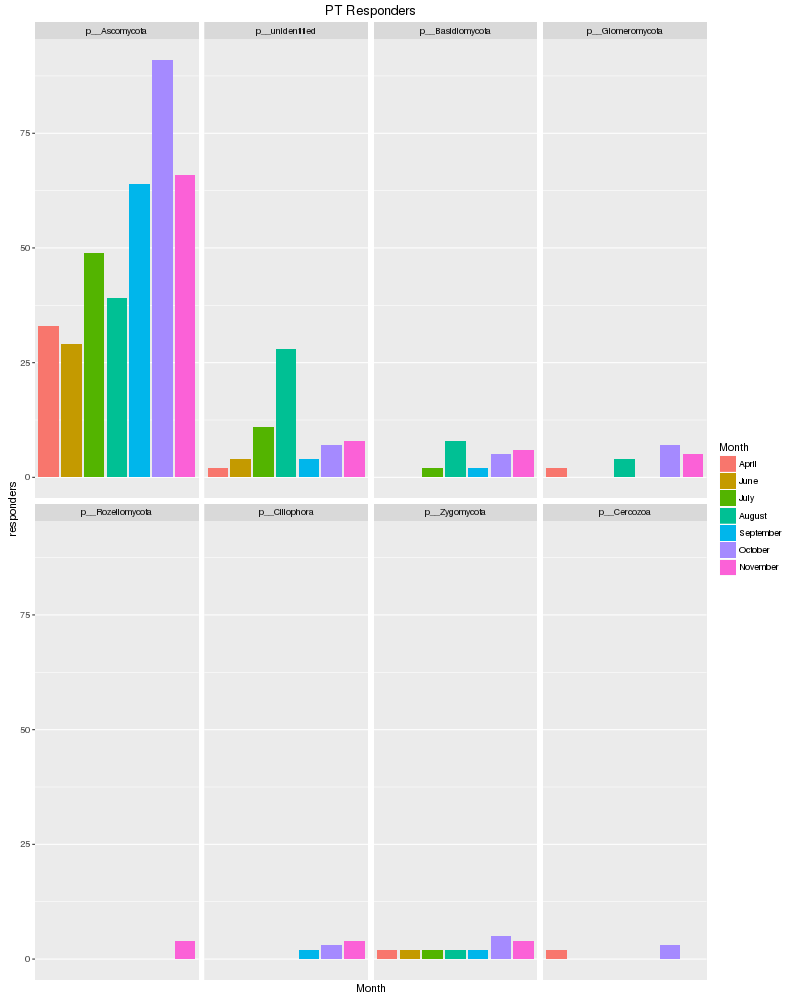

In [53]:
%%R -w 800 -h 1000
dcounts = df.l2fc %>%
          filter(!is.na(log2FoldChange)) %>%
          filter(!is.na(padj)) %>%
          filter(log2FoldChange < 0) %>%
          group_by(Rank2,Month) %>%
          summarize(responders = sum(padj<= 0.10))
dcounts = filter(dcounts, responders > 1)
dcounts$Rank2 <- droplevels(dcounts$Rank2) 
dcounts$Rank2 = reorder(dcounts$Rank2, -dcounts$responders)

p = ggplot(dcounts, aes(x = Month , y = responders, fill = Month)) +
    geom_bar(stat = "identity") + scale_x_discrete(breaks=NULL) +
    facet_wrap( ~ Rank2, ncol = 4, nrow = 7) + ggtitle("PT Responders")


p

In [54]:
%%R
dcounts$responders

 [1] 33 29 49 39 64 91 66  2  8  2  5  6  2  3  2  3  4  2  4  7  5  4  2  4 11
[26] 28  4  7  8  2  2  2  2  2  5  4


In [55]:
%%R
new_df.l2fc$Resp_status[new_df.l2fc$padj > 0.10] = "non-responder"
new_df.l2fc$Resp_status[new_df.l2fc$padj <= 0.10 & new_df.l2fc$log2FoldChange > 0] = "NT enriched"
new_df.l2fc$Resp_status[new_df.l2fc$padj <= 0.10 &  new_df.l2fc$log2FoldChange < 0] = "PT enriched"


Error in new_df.l2fc$Resp_status[new_df.l2fc$padj > 0.1] = "non-responder" : 
  object 'new_df.l2fc' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in new_df.l2fc$Resp_status[new_df.l2fc$padj > 0.1] = "non-responder" : 
  object 'new_df.l2fc' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [56]:
%%R
NT = filter(new_df.l2fc, Month == "November")
PT = filter(new_df.l2fc, Month == "November")
#length(unique(intersect(NT$OTU, PT$OTU)))
length((NT$OTU))


Error in filter_(.data, .dots = lazyeval::lazy_dots(...)) : 
  object 'new_df.l2fc' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in filter_(.data, .dots = lazyeval::lazy_dots(...)) : 
  object 'new_df.l2fc' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [57]:
%%R
ggsave(filename = "figs/PTvsNT_phyla_wmonths.png", plot = p, width =16, height =8)


Error in grid.newpage() : 
  could not open file 'figs/PTvsNT_phyla_wmonths.png'


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in grid.newpage() : 
  could not open file 'figs/PTvsNT_phyla_wmonths.png'

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [58]:
%%R
ggsave(filename = "figs/PTvsNT_phyla.png", plot = p, width =14, height =14)


Error in grid.newpage() : could not open file 'figs/PTvsNT_phyla.png'


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in grid.newpage() : could not open file 'figs/PTvsNT_phyla.png'

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [59]:
%%R
d = (filter(new_df.l2fc, Resp_status =="NT responder"))
length(d$OTU)
length(unique(d$OTU))


Error in filter_(.data, .dots = lazyeval::lazy_dots(...)) : 
  object 'new_df.l2fc' not found


In [60]:
%%R
e = (filter(new_df.l2fc, Resp_status =="PT responder"))
length(e$OTU)
length(unique(e$OTU))


Error in filter_(.data, .dots = lazyeval::lazy_dots(...)) : 
  object 'new_df.l2fc' not found


In [61]:
%%R -w 700 -h 700
p = ggplot(new_df.l2fc, aes(log2FoldChange, Rank2))
p = p + geom_point(aes(color = Resp_status))
#p = p + xlab("RNA log2-fold change") + ylab("DNA log2-fold change")
#p = p + scale_colour_discrete((name="Responder Status"),
 #                        labels =c("Nonresponder/Unknown", "DNA and RNA Responder"))
p


Error in ggplot(new_df.l2fc, aes(log2FoldChange, Rank2)) : 
  object 'new_df.l2fc' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in ggplot(new_df.l2fc, aes(log2FoldChange, Rank2)) : 
  object 'new_df.l2fc' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [62]:
%%R -w 700 -h 700
p = ggplot(new_df.l2fc, aes(log2FoldChange, Rank2))
p = p + geom_point(aes(color = Resp_status))
p = p + facet_wrap(~Month)
#p = p + xlab("RNA log2-fold change") + ylab("DNA log2-fold change")
p = p + scale_colour_discrete((name="Responder Status"))
p = p + ylab("Phylum")
p


Error in ggplot(new_df.l2fc, aes(log2FoldChange, Rank2)) : 
  object 'new_df.l2fc' not found


In [63]:
%%R -w 1000 -h 400
new_df.l2fc_2 = filter(new_df.l2fc, padj <=0.10)
p = ggplot(new_df.l2fc_2, aes(log2FoldChange, Rank2))
p = p + geom_point(aes(color = Resp_status))
p = p + facet_wrap(~Month, ncol = 4)
#p = p + xlab("RNA log2-fold change") + ylab("DNA log2-fold change")
p = p + scale_colour_discrete((name="Responder Status"))
p = p + ylab("Phylum")
p


Error in filter_(.data, .dots = lazyeval::lazy_dots(...)) : 
  object 'new_df.l2fc' not found


In [64]:
%%R
ggsave(filename = "figs/NT_PT_phyla.png", plot = p, width =10, height =3)


Error in grid.newpage() : could not open file 'figs/NT_PT_phyla.png'


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in grid.newpage() : could not open file 'figs/NT_PT_phyla.png'

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [65]:
%%R -w 700 -h 700
July = filter(new_df.l2fc, Month == "July") %>%
        group_by(OTU) 
Sept = filter(new_df.l2fc, Month == "September")%>%
        group_by(OTU)
JS2 = right_join(July, Sept, by = "OTU")


Error in filter_(.data, .dots = lazyeval::lazy_dots(...)) : 
  object 'new_df.l2fc' not found


In [66]:
%%R
JS2$Resp_status[JS2$padj.x > 0.10 & JS2$padj.y >0.10] = "unknown/non-responder"
JS2$Resp_status[JS2$padj.x <= 0.10 & JS2$log2FoldChange.x > 0 & JS2$padj.y <= 0.10 & JS2$log2FoldChange.y > 0] = "NT responder both"
JS2$Resp_status[JS2$padj.x <= 0.10 & JS2$log2FoldChange.x < 0 & JS2$padj.y <= 0.10 & JS2$log2FoldChange.y < 0] = "PT responder both"
JS2$Resp_status[JS2$padj.x <= 0.10 & JS2$log2FoldChange.x < 0 & JS2$padj.y > 0.10] = "PT responder July"
JS2$Resp_status[JS2$padj.x > 0.10  & JS2$padj.y <= 0.10 & JS2$log2FoldChange.y < 0] = "PT responder Sept"
JS2$Resp_status[JS2$padj.x <= 0.10 & JS2$log2FoldChange.x > 0 & JS2$padj.y > 0.10] = "NT responder July"
JS2$Resp_status[JS2$padj.x > 0.10  & JS2$padj.y <= 0.10 & JS2$log2FoldChange.y > 0] = "NT responder Sept"


Error in JS2$Resp_status[JS2$padj.x > 0.1 & JS2$padj.y > 0.1] = "unknown/non-responder" : 
  object 'JS2' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in JS2$Resp_status[JS2$padj.x > 0.1 & JS2$padj.y > 0.1] = "unknown/non-responder" : 
  object 'JS2' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [67]:
%%R
head(JS2)


Error in head(JS2) : object 'JS2' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in head(JS2) : object 'JS2' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [68]:
%%R -w 600 -h 600
p = ggplot(JS2, aes(log2FoldChange.x, log2FoldChange.y))
p = p + geom_point(aes(color = Resp_status))
p = p + xlab("July log2-fold change") + ylab("September log2-fold change")
p = p + scale_colour_discrete(name="Responder Status")
p = p + theme(text=element_text(size = 20))
p


Error in ggplot(JS2, aes(log2FoldChange.x, log2FoldChange.y)) : 
  object 'JS2' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in ggplot(JS2, aes(log2FoldChange.x, log2FoldChange.y)) : 
  object 'JS2' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [69]:
%%R
Sept = filter(new_df.l2fc, Month == "September") %>%
        group_by(OTU) 
Oct = filter(new_df.l2fc, Month == "October")%>%
        group_by(OTU)
SO = right_join(Sept, Oct, by = "OTU")


Error in filter_(.data, .dots = lazyeval::lazy_dots(...)) : 
  object 'new_df.l2fc' not found


In [70]:
%%R
SO$Resp_status[SO$padj.x > 0.10 & SO$padj.y >0.10] = "unknown/non-responder"
SO$Resp_status[SO$padj.x <= 0.10 & SO$log2FoldChange.x > 0 & SO$padj.y <= 0.10 & SO$log2FoldChange.y > 0] = "NT responder both"
SO$Resp_status[SO$padj.x <= 0.10 & SO$log2FoldChange.x < 0 & SO$padj.y <= 0.10 & SO$log2FoldChange.y < 0] = "PT responder both"
SO$Resp_status[SO$padj.x <= 0.10 & SO$log2FoldChange.x < 0 & SO$padj.y > 0.10] = "PT responder Sept"
SO$Resp_status[SO$padj.x > 0.10  & SO$padj.y <= 0.10 & SO$log2FoldChange.y < 0] = "PT responder Oct"
SO$Resp_status[SO$padj.x <= 0.10 & SO$log2FoldChange.x > 0 & SO$padj.y > 0.10] = "NT responder Sept"
SO$Resp_status[SO$padj.x > 0.10  & SO$padj.y <= 0.10 & SO$log2FoldChange.y > 0] = "NT responder Oct"


Error in SO$Resp_status[SO$padj.x > 0.1 & SO$padj.y > 0.1] = "unknown/non-responder" : 
  object 'SO' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in SO$Resp_status[SO$padj.x > 0.1 & SO$padj.y > 0.1] = "unknown/non-responder" : 
  object 'SO' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [71]:
%%R -w 600 -h 600
p = ggplot(JS2, aes(log2FoldChange.x, log2FoldChange.y))
p = p + geom_point(aes(color = Resp_status))
p = p + xlab("July log2-fold change") + ylab("September log2-fold change")
p = p + scale_colour_discrete(name="Responder Status")
p = p + theme(text=element_text(size = 20))
p


Error in ggplot(JS2, aes(log2FoldChange.x, log2FoldChange.y)) : 
  object 'JS2' not found


## Blasting against Living Tree Project db

In [72]:
from Bio.Blast.Applications import NcbiblastnCommandline as blast

In [73]:
from cogent import LoadSeqs, DNA


In [74]:
OTU_ids = ["OTU.162", "OTU.239", "OTU.2456", "OTU.256", "OTU.3194", "OTU.80"]
seqs = LoadSeqs("/home/chantal/RNASIP/data/totalRNA.otusn.fasta", moltype=DNA, aligned=False)
seqs = seqs.takeSeqs(OTU_ids).toFasta()
print seqs

>OTU.162
TACGTAGGGTGCAAGCGTTGTCCGGAATTATTGGGCGTAAAGAGCTCGTAGGCGGTTTGTCGCGTCTGCTGTGAAATCTGGGGGCTCAACCCCCAGCCTGCAGTGGGTACGGGCAGACTAGAGTGCGGTAGGGGAGATTGGAATTCCTGGTGTAGCGGTGGAATGCGCAGATATCAGGAGGAACACCGATGGCGAAGGCAGATCTCTGGGCCGTAACTGACGCTGAGGAGCGAAAGCATGGGGAGCGAACAGGATTAGATACCCTGGTAGTCCATGCCGTAAACGTTGGGAACTAGATGTGGGGACCATTCCACGGTCTCCGTGTCGCAGCTAACGCATTAAGTTCCCCGCCTGGGGAGTACGGCCGCAAGGCTA
>OTU.239
TACGGAGGGAGCTAGCGTTATTCGGAATTACTGGGCGTAAAGCGCACGTAGGCGGCTTTGTAAGTTAGAGGTGAAAGCCCAGAGCTCAACTCTGGAATAGCCTTTAAGACTGCATCGCTTGAATCCAGGAGAGGTGAGTGGAATTCCGAGTGTAGAGGTGAAATTCGTAGATATTCGGAAGAACACCAGTGGCGAAGGCGGCTCACTGGACTGGTATTGACGCTGAGGTGCGAAAGCGTGGGGAGCAAACAGGATTAGATACCCTGGTAGTCCACGCCGTAAACGATGATAACTAGCTGTCTGGGTGCTTGGCACTTAGGTGGCGCAGCTAACGCATTAAGTTATCCGCCTGGGGAGTACGGTCGCAAGATTA
>OTU.2456
TACGGAGGGTGCAAGCGTTATCCGGATTCACTGGGTTTAAAGGGTGCGTAGGCGGGCATATAAGTCAGTGGTGAAATCCCCGAGCTTAACTTGGGAACTGCCATTGATACTATGTGTCTTGAATATCGCGGAGGTAAGCGGAATATGTCATGTAGCGGTGAAATGCATAGATATGACATAGAACACCGATTGCGAAGGCAGCTTACTACACGATCATTGACG

In [75]:
my_file = open("seqs.fasta", "w")
my_file.write(seqs)
my_file.close()

In [76]:
cline = blast(query = "seqs.fasta",
              db = "/var/seq_data/silva/silva_blastdb/silva_RefNR_115",
              outfmt = 6,
              out = "otusn_silvaRefNR115.m6",
              num_threads = 5)
print cline
cline()

blastn -out otusn_silvaRefNR115.m6 -outfmt 6 -query seqs.fasta -db /var/seq_data/silva/silva_blastdb/silva_RefNR_115 -num_threads 5


('', '')

In [77]:
!head -n1 otusn_silvaRefNR115.m6
!wc -l otusn_silvaRefNR115.m6
! grep -c "OTU.80" otusn_silvaRefNR115.m6

OTU.162	HQ256829	100.00	375	0	0	1	375	445	819	0.0	  693
3000 otusn_silvaRefNR115.m6
500


In [78]:
from IPython.display import Image
import pandas.rpy.common as com

/opt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: The pandas.rpy module is deprecated and will be removed in a future version. We refer to external packages like rpy2. 
See here for a guide on how to port your code to rpy2: http://pandas.pydata.org/pandas-docs/stable/r_interface.html
  from ipykernel import kernelapp as app


In [79]:
%%R
library(data.table)
library(dplyr)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: data.table 1.9.6  For help type ?data.table or https://github.com/Rdatatable/data.table/wiki

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The fastest way to learn (by data.table authors): https://www.datacamp.com/courses/data-analysis-the-data-table-way

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘data.table’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:reshape2’:

    dcast, melt


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106:

In [80]:
%%R
blastout_dt = fread("otusn_silvaRefNR115.m6")
blastout_df = tbl_df(blastout_dt)
colnames(blastout_df) = c("OTU",
                        "acc",
                        "pid",
                        "aln.length",
                        "mismatches",
                        "gapOpenCount",
                        "qstart",
                        "qend",
                        "sstart",
                        "send",
                        "e.value",
                        "bit.score")

top_hits_df_LTP = blastout_df %>% 
                          group_by(OTU) %>% 
                          mutate(Rank = rank(desc(bit.score), ties.method = "min")) %>% 
                          filter(pid > 97.0) %>%
                          filter(e.value < 5.0e-180) %>%
                          filter(acc %in% c('AM286414', 'AB428568', 'EU877263', 'EF575565', 'EF494193', 'X82449'))


Error in eval(expr, envir, enclos) : 
  unable to find an inherited method for function ‘desc’ for signature ‘"integer"’


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in eval(expr, envir, enclos) : 
  unable to find an inherited method for function ‘desc’ for signature ‘"integer"’

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [81]:
%%R
print(head(top_hits_df_LTP))
str(top_hits_df_LTP$OTU)


Error in head(top_hits_df_LTP) : object 'top_hits_df_LTP' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in head(top_hits_df_LTP) : object 'top_hits_df_LTP' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [82]:
%%R
dt = fread("/var/seq_data/LTP115_db/LTPs115_SSU.csv", sep = ";")
colnames(dt) = c("acc","start","end","DB.version","name","unknown1","family","unknown2","url","full_tax")
LTP_seq_data = tbl_df(dt)

In [83]:
%%R
joined_df = left_join(top_hits_df_LTP, LTP_seq_data)


Error in left_join(top_hits_df_LTP, LTP_seq_data) : 
  object 'top_hits_df_LTP' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in left_join(top_hits_df_LTP, LTP_seq_data) : 
  object 'top_hits_df_LTP' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [84]:
%%R
joined_df = filter(joined_df, name != "NA")


Error in filter_(.data, .dots = lazyeval::lazy_dots(...)) : 
  object 'joined_df' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in filter_(.data, .dots = lazyeval::lazy_dots(...)) : 
  object 'joined_df' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [85]:
%%R
dim(joined_df)


Error in withVisible({ : object 'joined_df' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in withVisible({ : object 'joined_df' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [86]:
df = com.load_data("joined_df")

LookupError: 'joined_df' not found

In [ ]:
def get_latex(df):
    latex = ""
    prefix = r"\multirow{%s}{*}{%s}"%(len(df.index), df.OTU.iloc[0])
    for i, r in df[["name","pid","acc"]].iterrows():
        latex += " & " + " & ".join([str(i) for i in r.values]) + r" \\ "
    return prefix + latex + r"\midrule" + "\n"

In [ ]:
s = df.groupby("OTU").apply(get_latex)

table_framework = r"""
\documentclass[11pt]{article}
\usepackage{multirow, array, booktabs}
\begin{document}

\thispagestyle{empty}
 
\begin{table}[ht]
\caption{$^{13}$C RNA responders BLAST against Living Tree Project}
\begin{center}
\begin{tabular}{l>{\itshape}lrl}
    \toprule \\
    \textbf{OTU ID} & \textbf{Species Name} & \textbf{BLAST percent identity} & \textbf{accession} \\
    \midrule
    %s
    \bottomrule
\end{tabular}
\end{center}
\label{tab:multicol}
\end{table}
 
\end{document}"""%"".join(s.values)

with open("../data/tmp/table.tex", "w") as out:
    out.write(table_framework)

In [ ]:
!latex -output-directory="../data/tmp" ../data/tmp/table.tex >/dev/null 2>&1 && \
dvipng -o ../data/table.png ../data/tmp/table.dvi >/dev/null 2>&1
Image("../data/table.png")